# Objectives:

### Declumping
- Visualize the effects of clump detection using threshold_drop
    - plot annotations for detected clumps and compare with reference spot locations
- Do any of these clumpy clusters show obvious degrees of clumpiness (lots of workers annotate 2x, 3x, etc)? If so, we’d have the k needed to apply partitioning, e.g. k-means, to that clump.
    - plot a histogram for the number of times each worker annotated a detected clump
    - plot the number of reference spots in the clumpy cluster vs. the fraction of workers who annotate the clumpy cluster the correct number of times
    
# Takeaways:

Clumps corresponding to two ref spots are a lot more common than clumps corresponding to three ref spots.
The fraction of workers who annotate two-spot clumps twice varies a lot. Meanwhile, none of these predicted-as-clumpy clusters are actually one-spot clumps. The overwhelming majority are two-spot clumps. The remainder are three-spot clumps, but very few workers annotate three-spot clumps three times, so we cannot detect for sure whether a clump should have three spots. Therefore, when trying to declump a cluster predicted as clumpy, we should always run clustering with k=2. Then, if any workers detected a third spot, we should run clustering again with k=3 and compare the performance of these two different clusterings.

I.e.

    run clustering with k=2
    if anyone annotates 3 times
        run clustering with k=3
        compare performance of clustering with k=2 vs. k=3

# Next steps:

- Apply partitioning to clumps
    - visualize and evaluate the performance of k-means applied to clumps
    - the k-finding problem has an added layer of complexity exemplifed at (50, 220) on the scatter plot for snr_5_0_density_0.008_spots.png: two centroids were found for three actual spots. These two centroids are considered different clusters.
- Flag areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness


# Guide to the scatter plots in this notebook
- Centroids are represented with unfilled circle markers.
    - The centroids of actual non-clumps (with only one reference spot within the area spanned by the cluster’s member annotations) are represented with bright blue unfilled circle markers.
    - The centroids of actual clumps (with at least two reference spots within the area spanned by the cluster’s member annotations) are represented with bright orange unfilled circle markers.
    - The centroids of incorrect clusters are represented with magenta unfilled circle markers.
- Annotations of “actually clumpy” clusters are represented with filled circle markers.
    - In some “actually clumpy” clusters, no contributing workers contributed more than one annotation. The member annotations of these clusters are shown as small light filled green circle markers.
    - In other “actually clumpy” clusters, at least one contributing worker contributed more than one annotation. THe member annotations of these clusters are shown small light pink filled circle markers.
- Reference annotations are represented with filled circle markers.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark purple circle marker.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark pink circle marker.
    - Other reference annotations are represented with light purple filled circle markers.


In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage import filters

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
show_correctness = False
correctness_threshold = 4
show_possible_clumps = False
clustering_params = ['AffinityPropagation', -350]

------------------- snr_5_0_density_0.002_spots.png -------------------
counts:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  2. 30.]
---
prev_count 30.0
count 2.0
threshold_drop 0.85


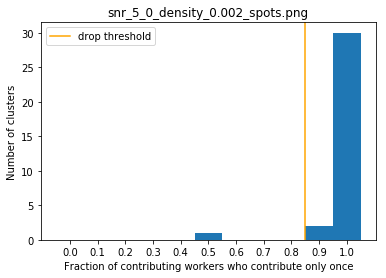

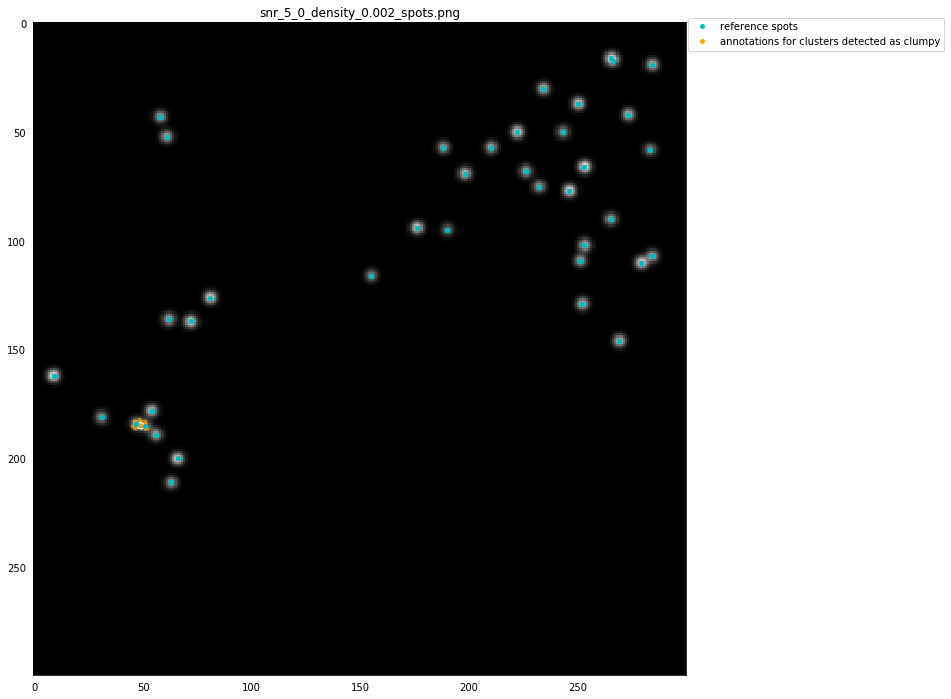

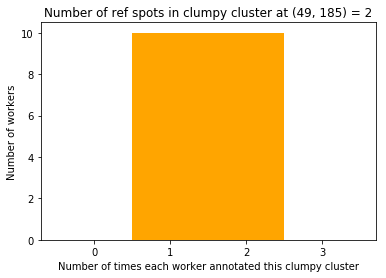

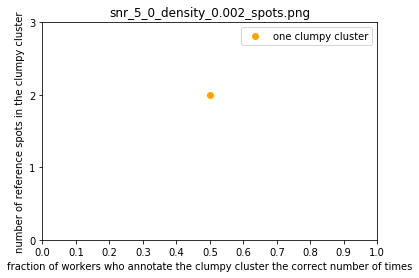

------------------- snr_5_0_density_0.004_spots.png -------------------
counts:
[ 0.  0.  0.  0.  1.  0.  0.  1.  3. 15. 50.]
---
prev_count 50.0
count 15.0
threshold_drop 0.85
---
prev_count 15.0
count 3.0
threshold_drop 0.75


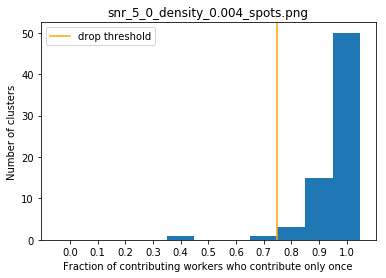

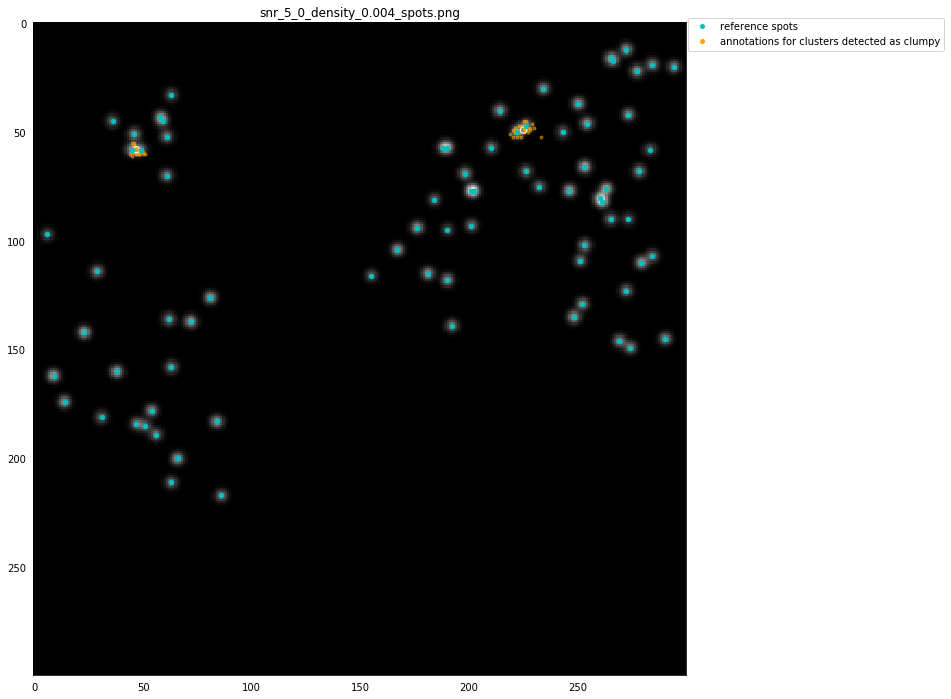

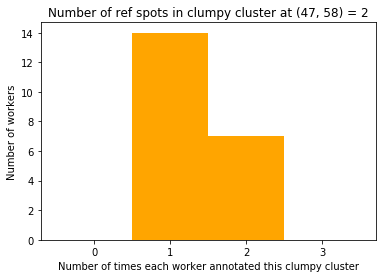

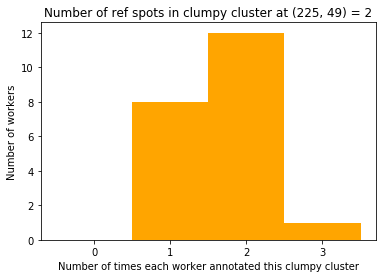

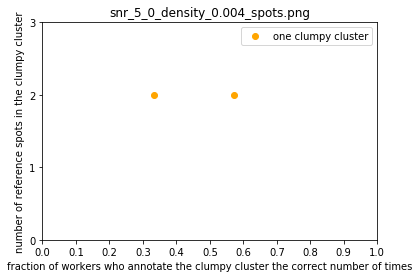

------------------- snr_5_0_density_0.006_spots.png -------------------
counts:
[ 0.  0.  0.  1.  0.  3.  2.  0.  5. 34. 51.]
---
prev_count 34.0
count 5.0
threshold_drop 0.75


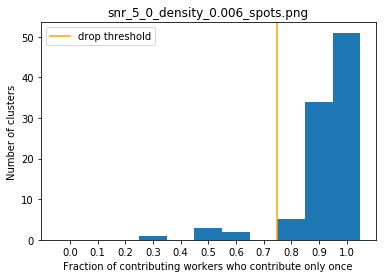

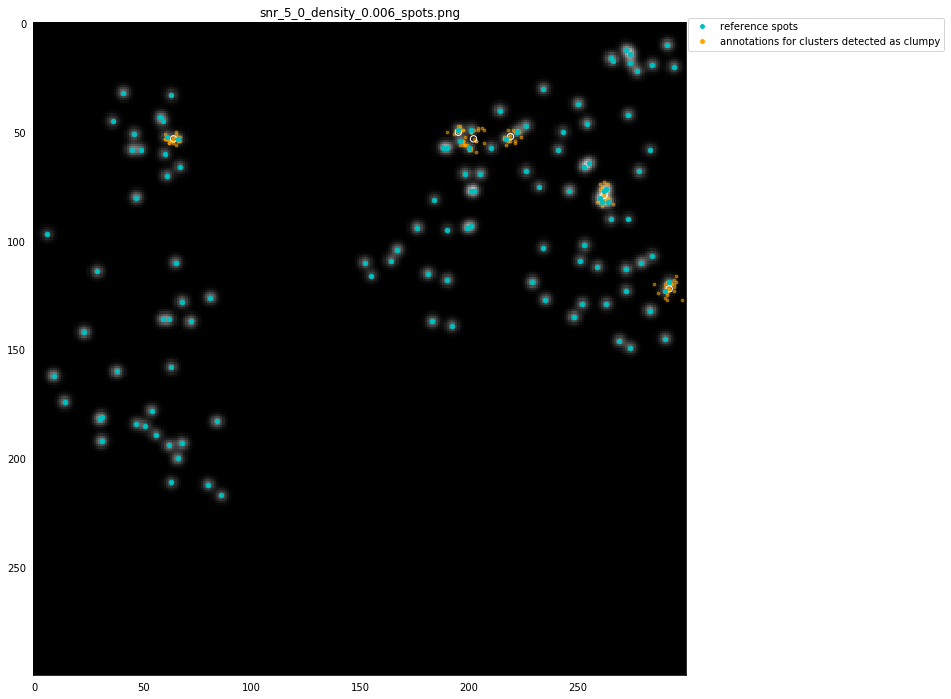

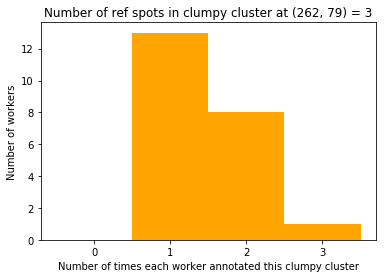

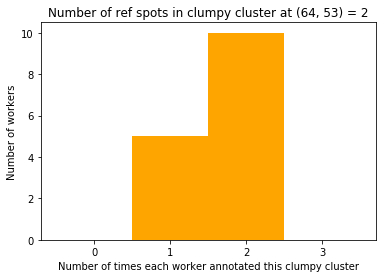

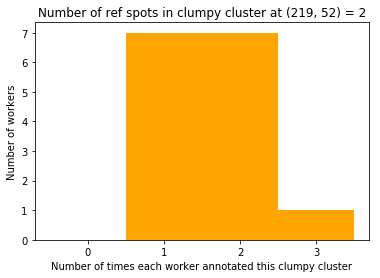

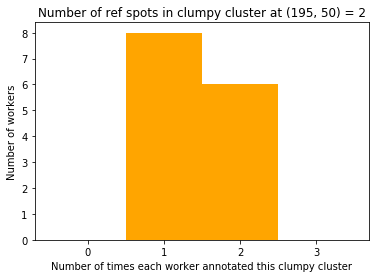

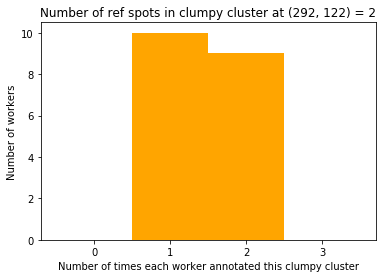

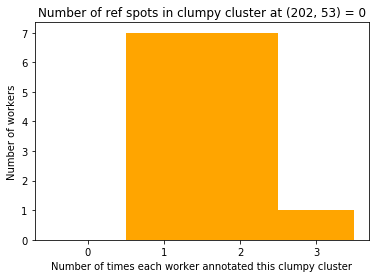

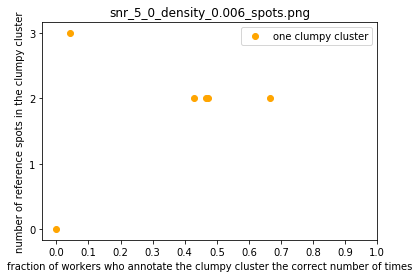

------------------- snr_5_0_density_0.008_spots.png -------------------
counts:
[ 0.  0.  0.  0.  3.  1.  5.  5. 10. 56. 37.]
---
prev_count 56.0
count 10.0
threshold_drop 0.75
---
prev_count 5.0
count 1.0
threshold_drop 0.45


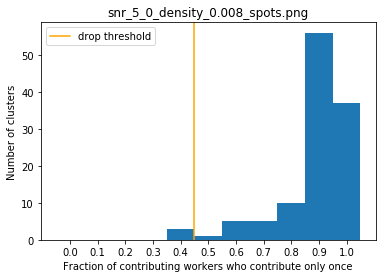

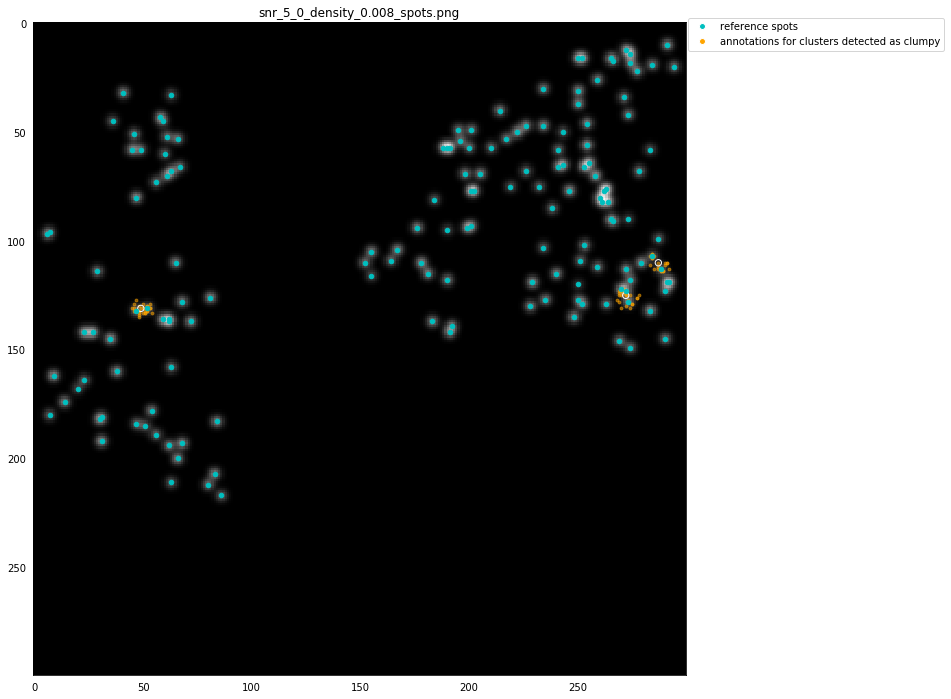

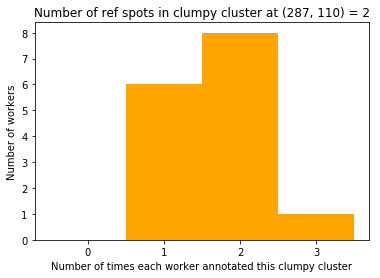

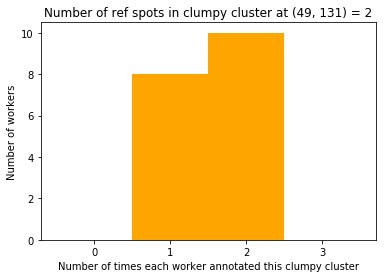

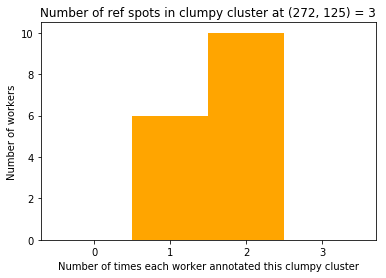

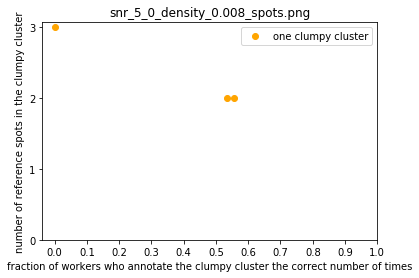

------------------- snr_10_0_density_0.002_spots.png -------------------
counts:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0. 36.]


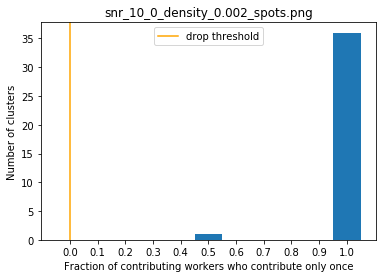

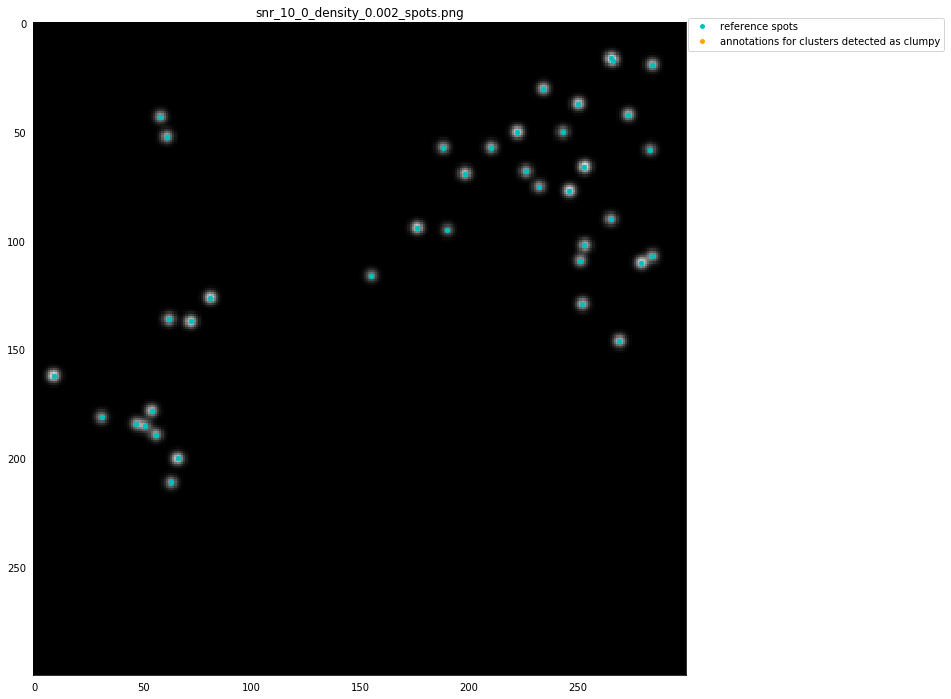

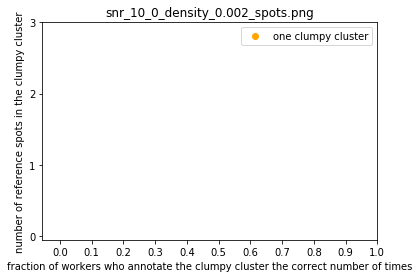

------------------- snr_10_0_density_0.004_spots.png -------------------
counts:
[ 0.  0.  0.  0.  1.  0.  0.  0.  1. 14. 54.]
---
prev_count 54.0
count 14.0
threshold_drop 0.85
---
prev_count 14.0
count 1.0
threshold_drop 0.75


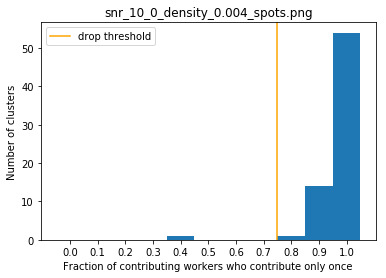

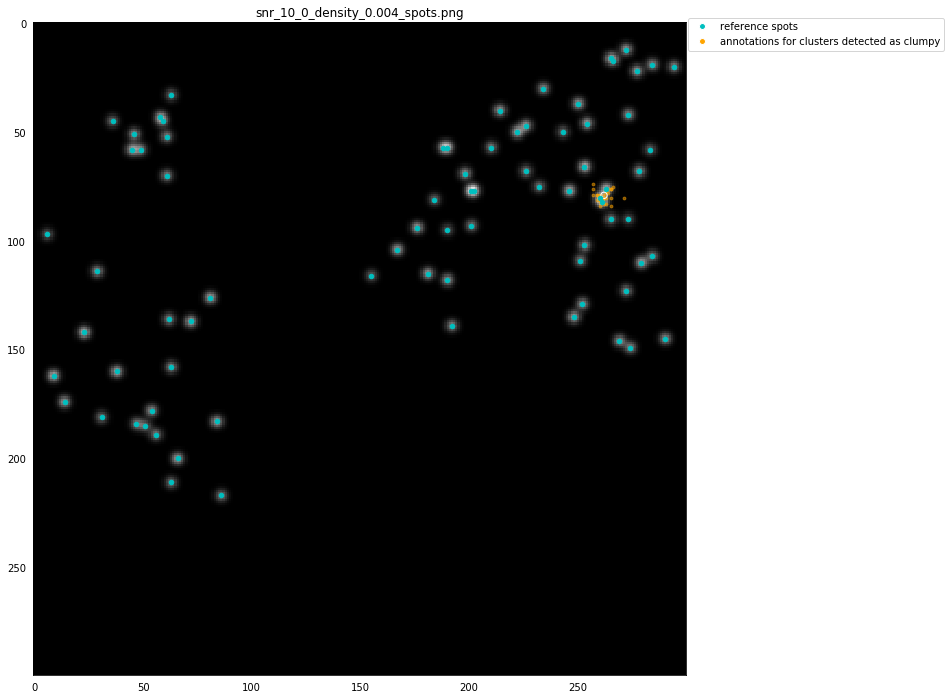

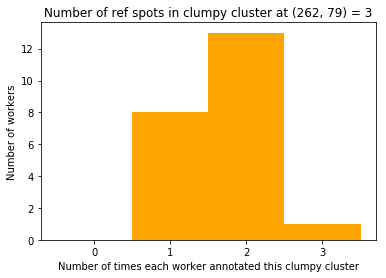

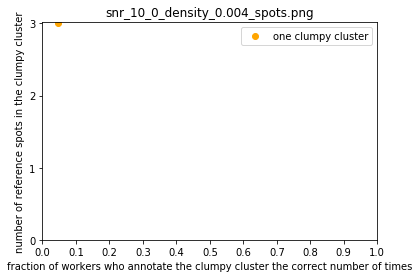

------------------- snr_10_0_density_0.006_spots.png -------------------
counts:
[ 0.  0.  0.  0.  1.  3.  1.  3.  5. 35. 48.]
---
prev_count 35.0
count 5.0
threshold_drop 0.75


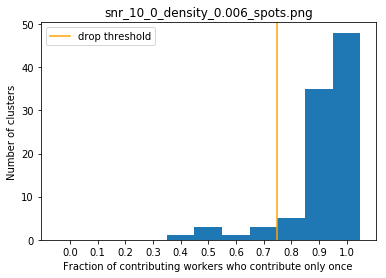

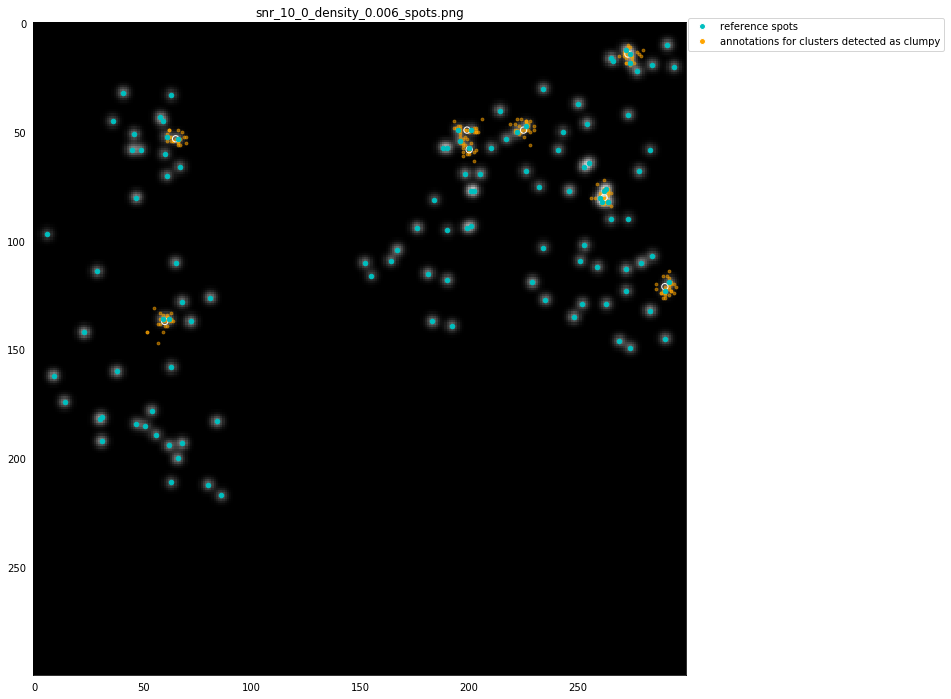

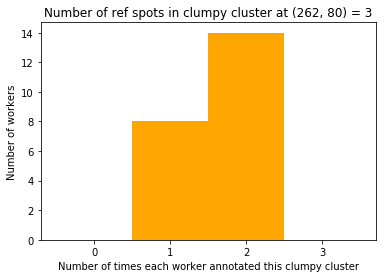

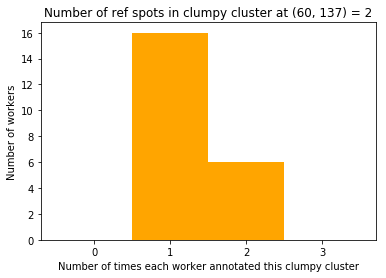

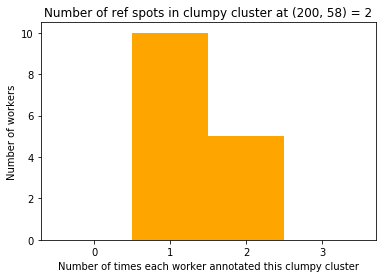

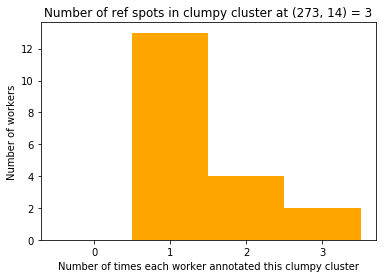

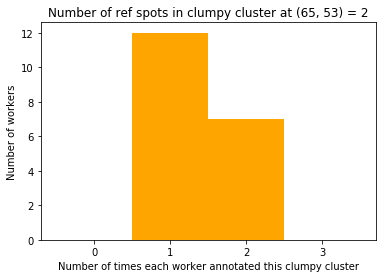

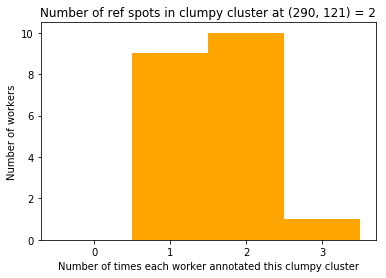

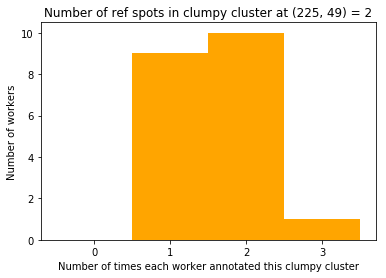

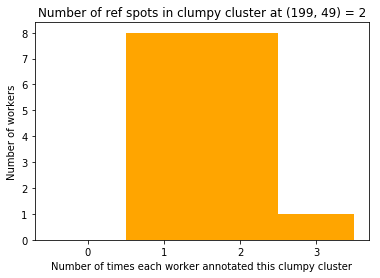

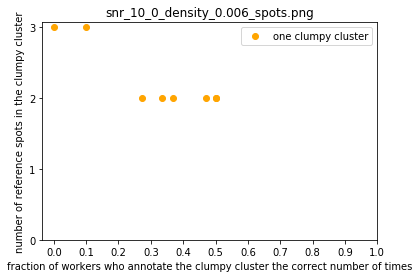

------------------- snr_10_0_density_0.008_spots.png -------------------
counts:
[ 0.  0.  0.  2.  1.  3.  3.  4.  7. 38. 58.]
---
prev_count 38.0
count 7.0
threshold_drop 0.75


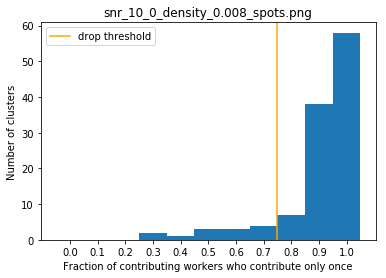

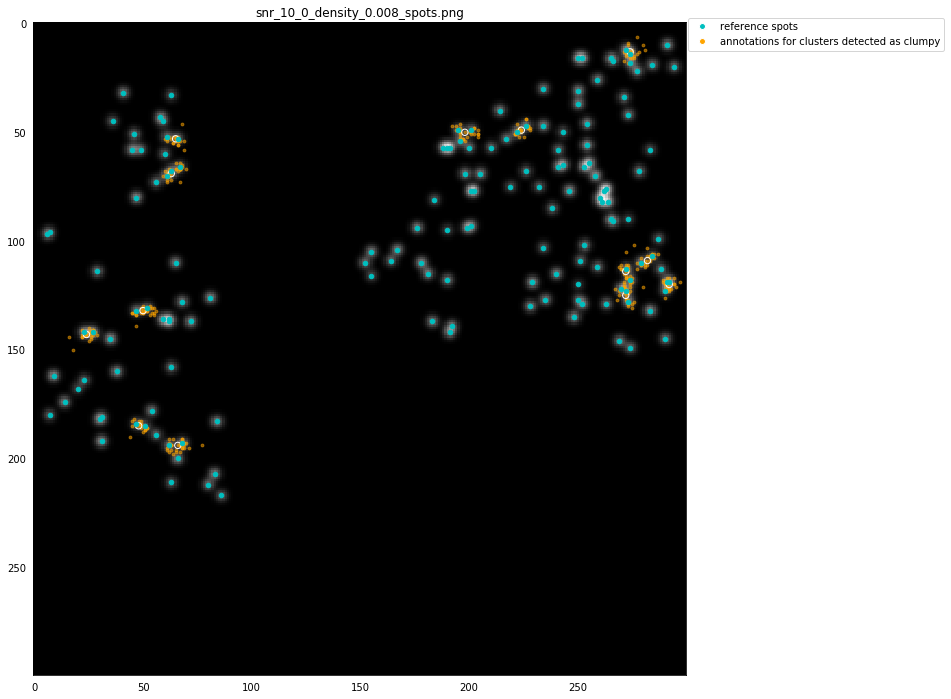

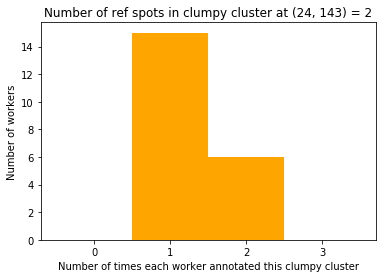

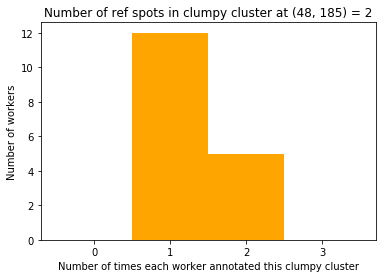

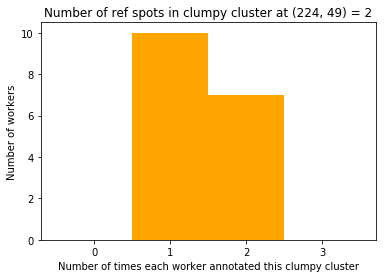

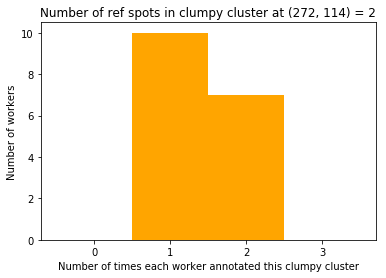

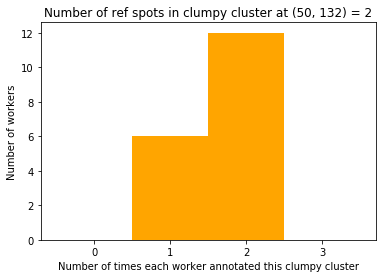

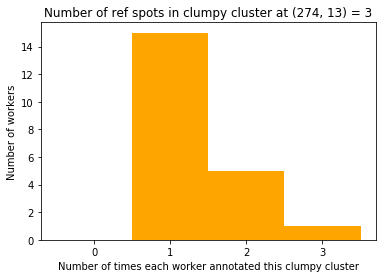

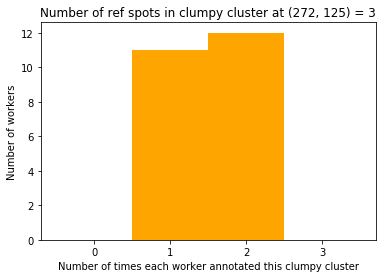

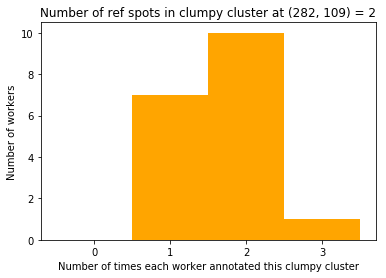

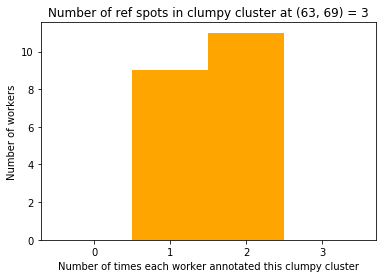

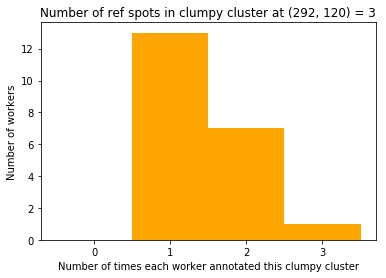

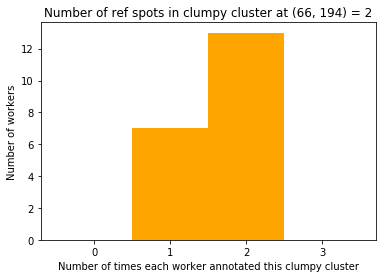

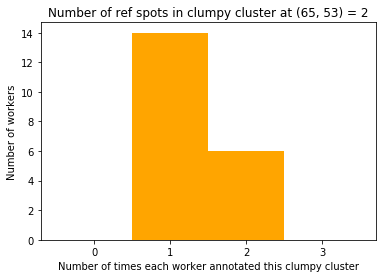

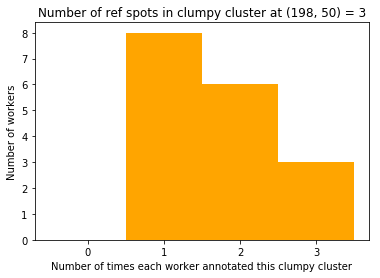

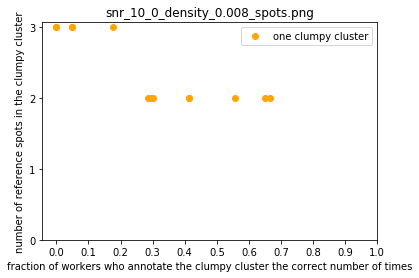

------------------- snr_5_0_density_0.002_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 22.]


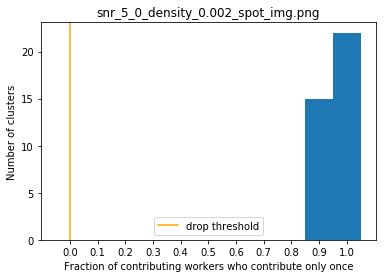

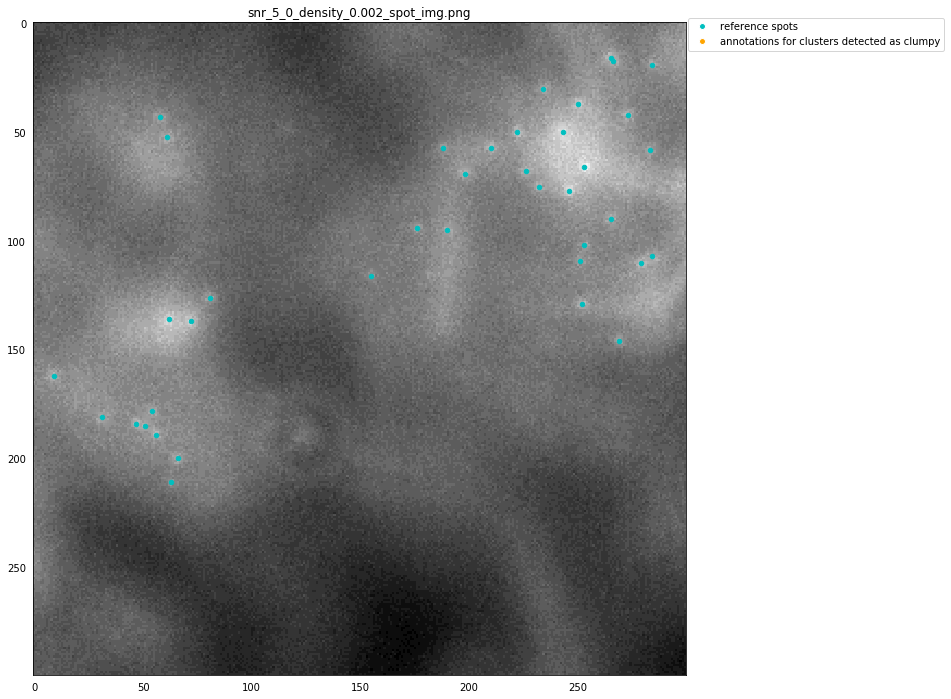

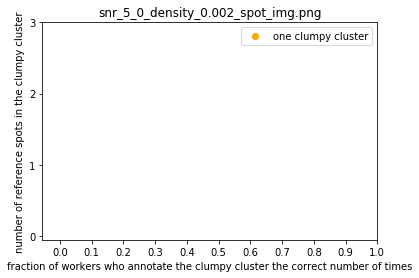

------------------- snr_5_0_density_0.004_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  2. 28. 38.]
---
prev_count 28.0
count 2.0
threshold_drop 0.75


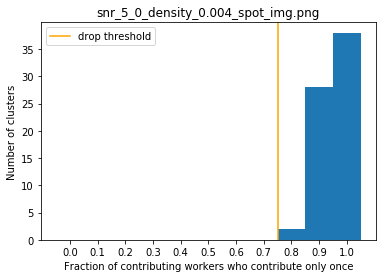

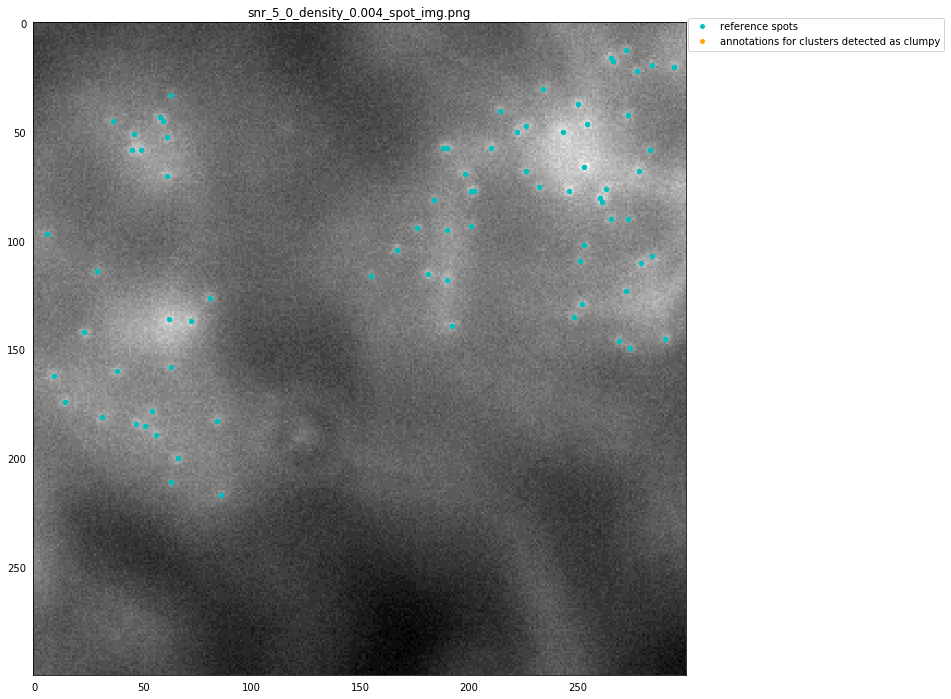

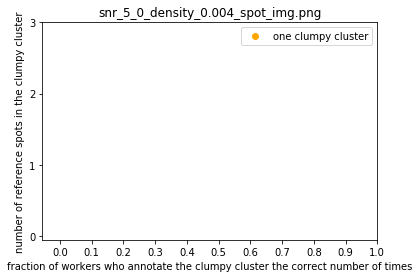

------------------- snr_5_0_density_0.006_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  2.  3.  3.  3. 32. 43.]
---
prev_count 32.0
count 3.0
threshold_drop 0.75


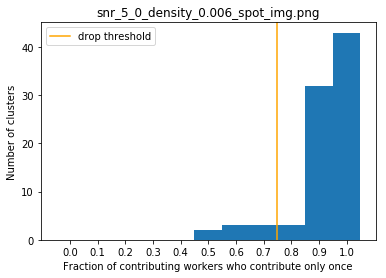

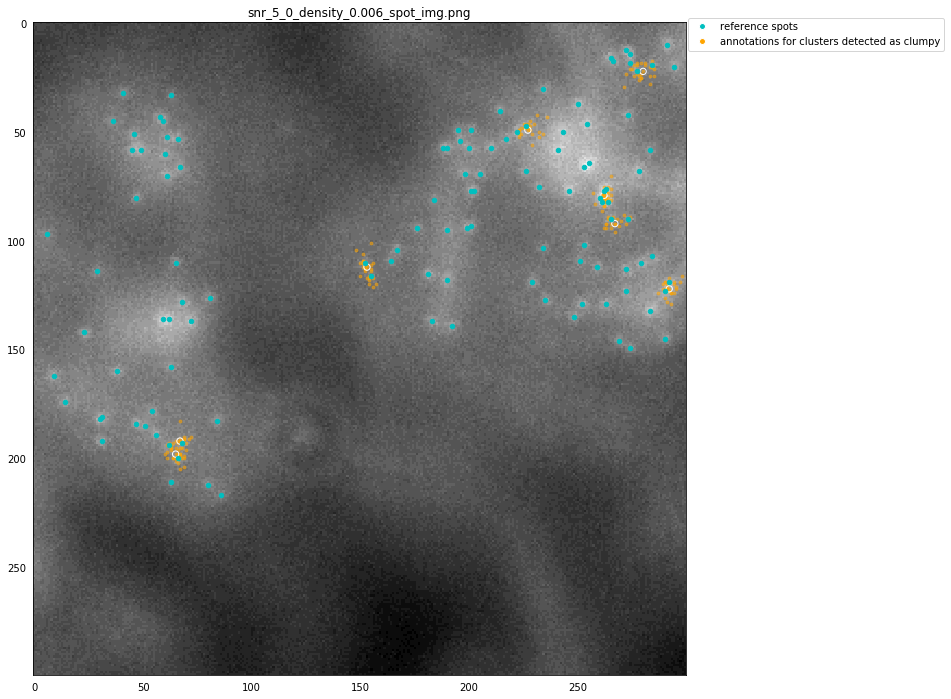

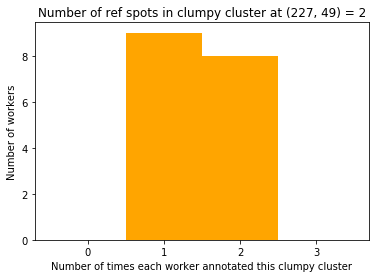

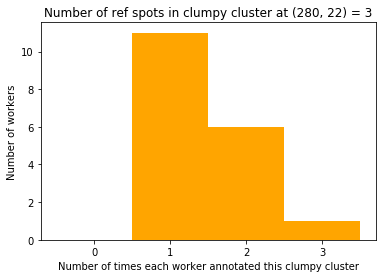

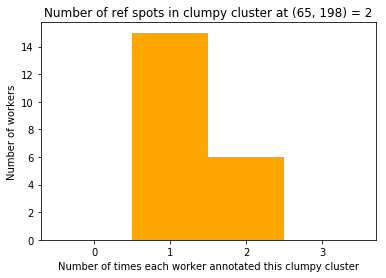

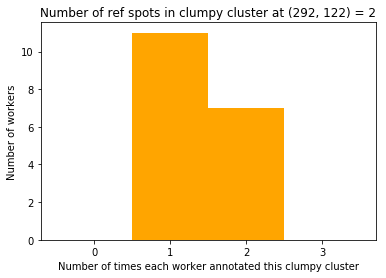

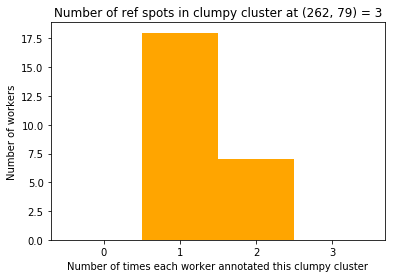

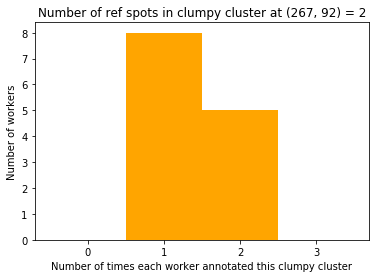

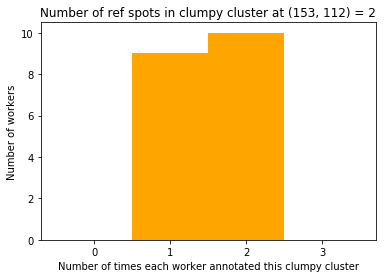

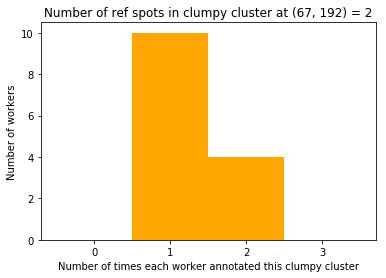

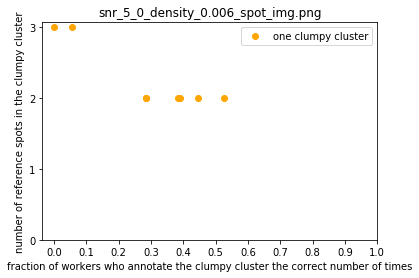

------------------- snr_5_0_density_0.008_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  1.  1.  3.  2.  9. 38. 34.]
---
prev_count 38.0
count 9.0
threshold_drop 0.75
---
prev_count 9.0
count 2.0
threshold_drop 0.65


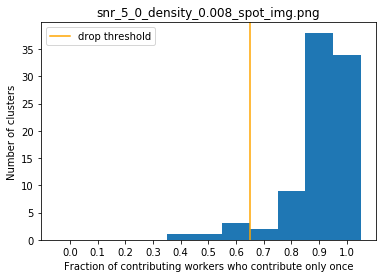

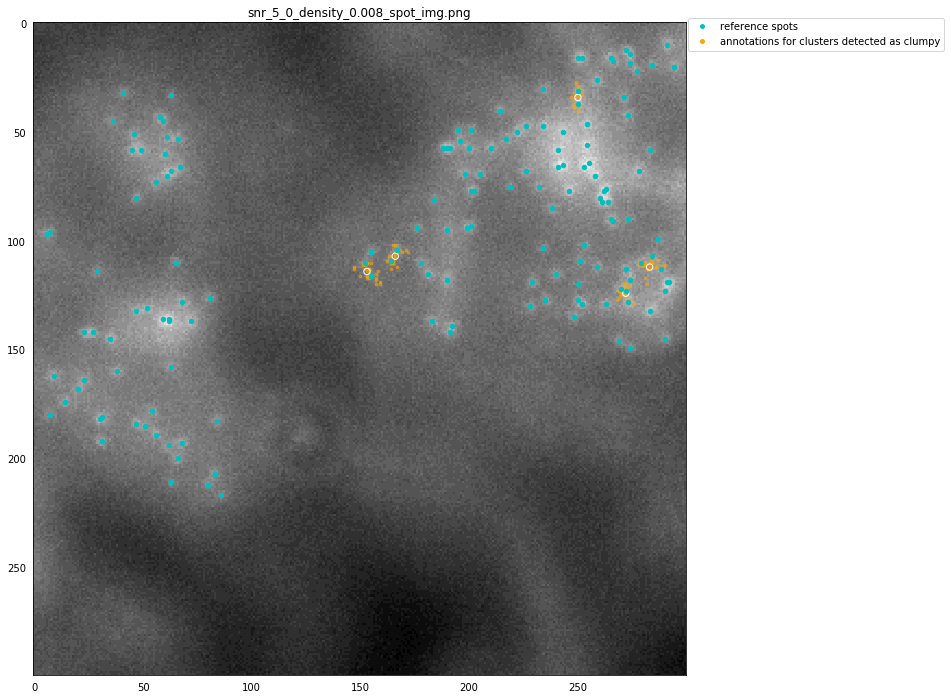

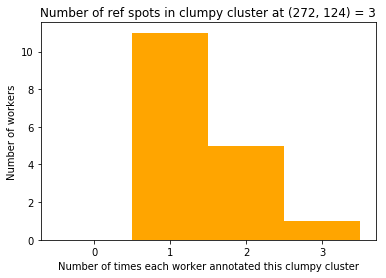

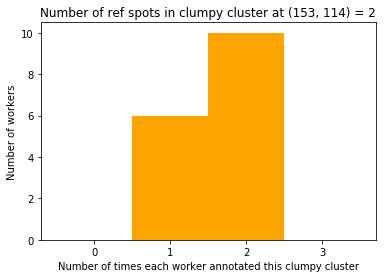

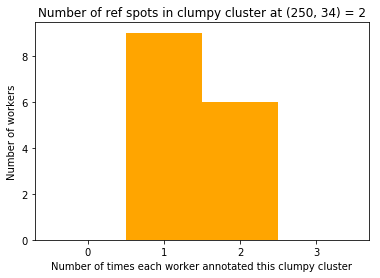

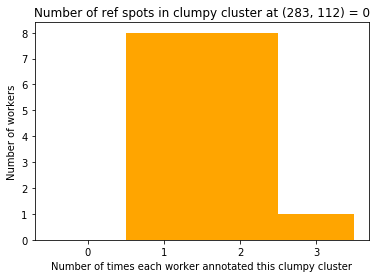

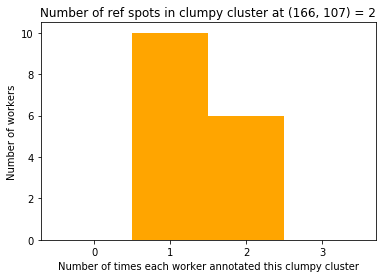

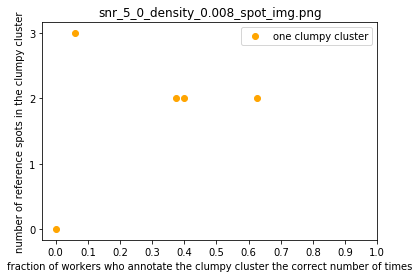

------------------- snr_10_0_density_0.002_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  2. 34.]
---
prev_count 34.0
count 2.0
threshold_drop 0.85


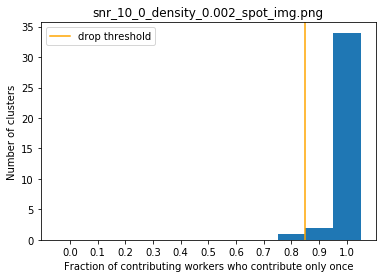

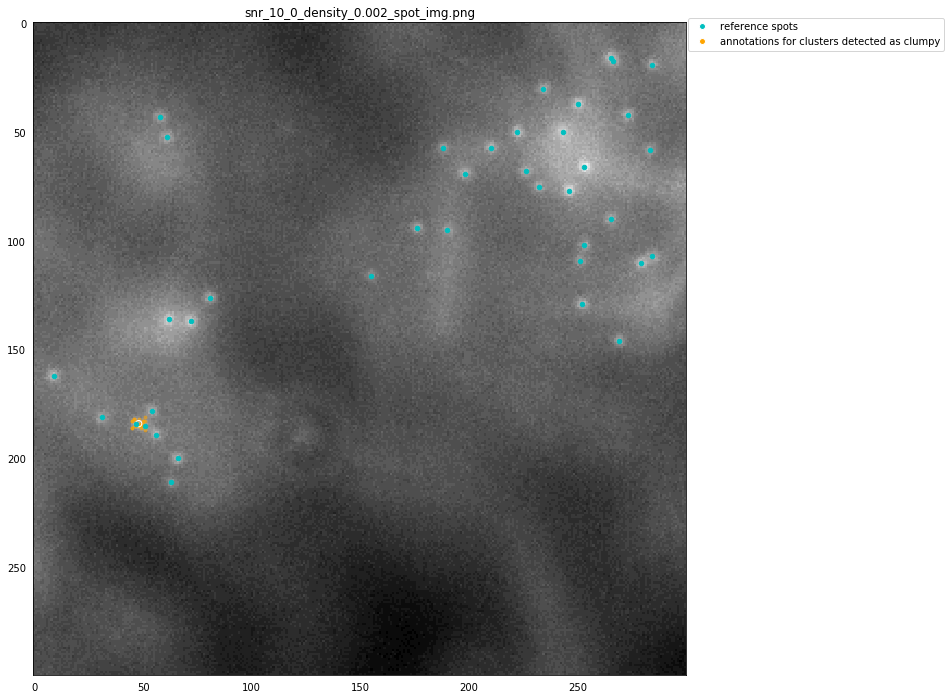

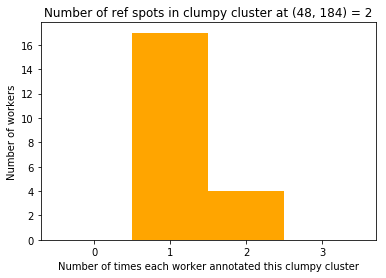

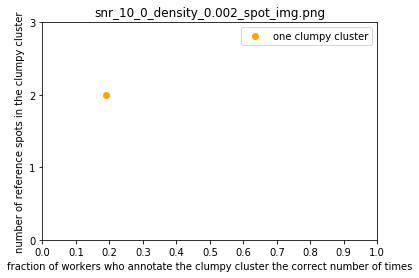

------------------- snr_10_0_density_0.004_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  1.  0.  0.  0.  4. 13. 52.]
---
prev_count 52.0
count 13.0
threshold_drop 0.85
---
prev_count 13.0
count 4.0
threshold_drop 0.75


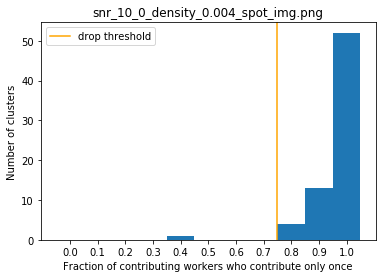

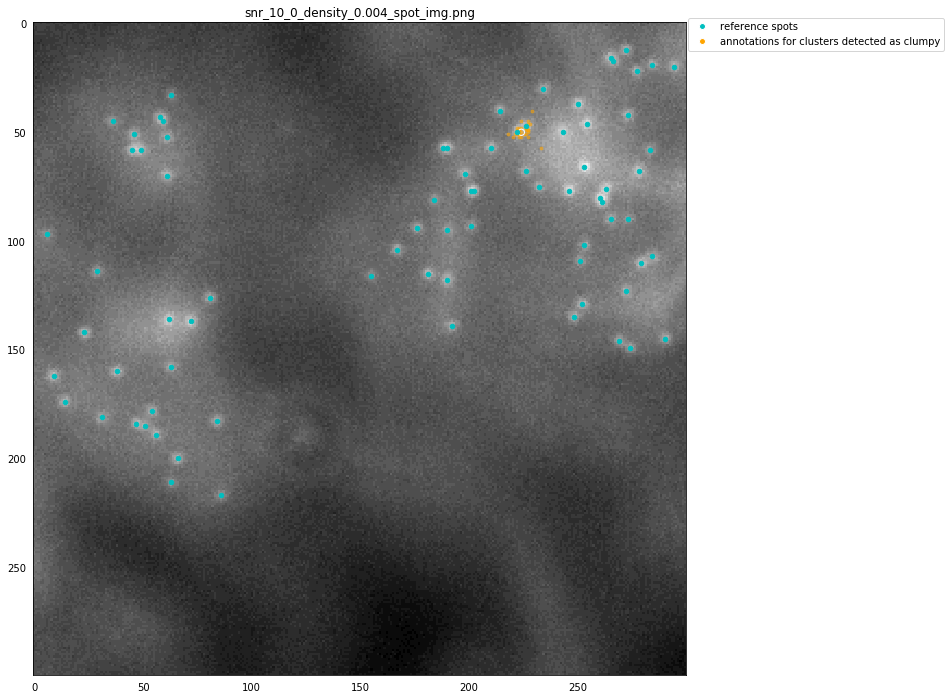

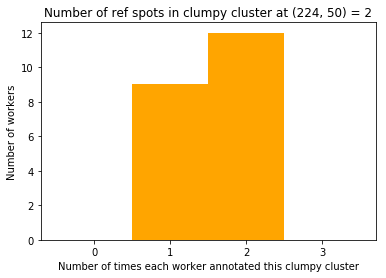

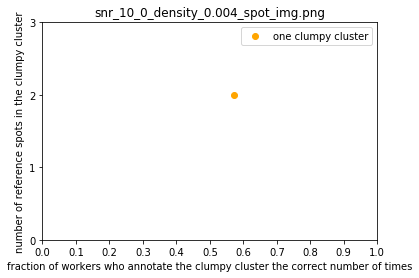

------------------- snr_10_0_density_0.006_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  1.  1.  2.  5. 36. 51.]
---
prev_count 36.0
count 5.0
threshold_drop 0.75


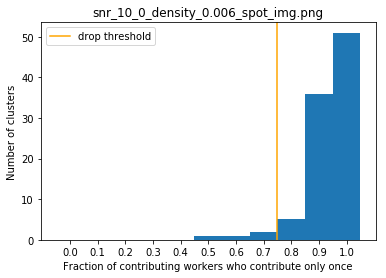

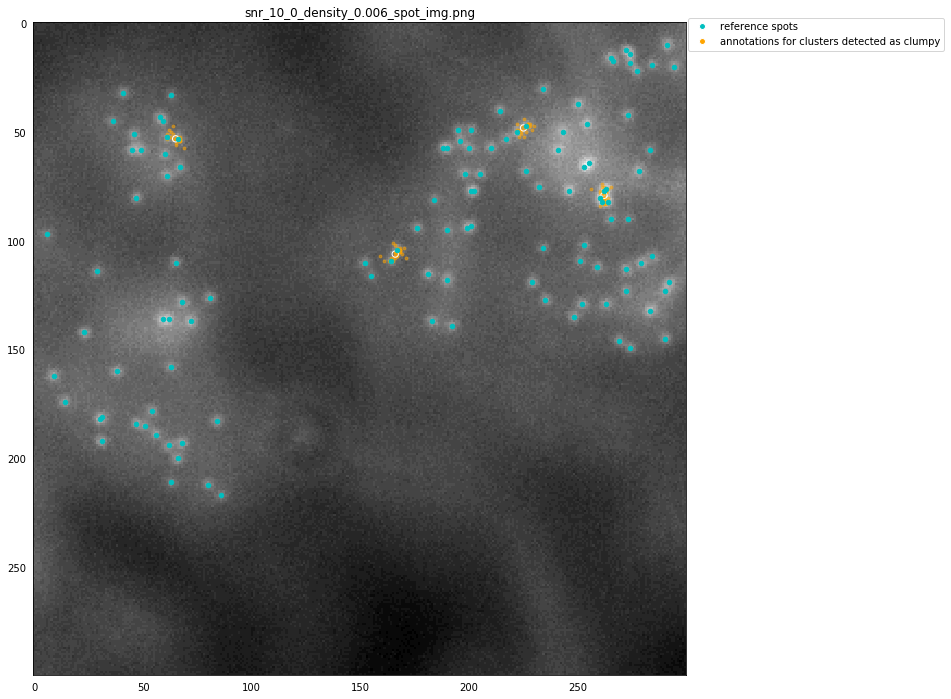

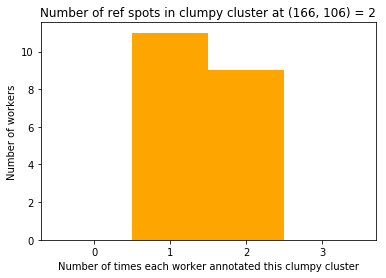

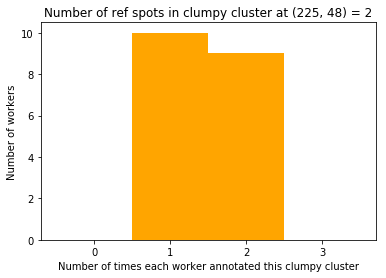

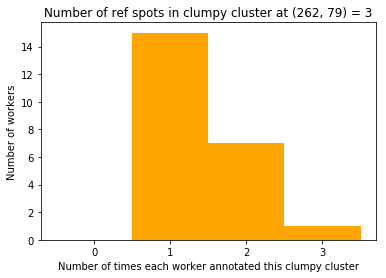

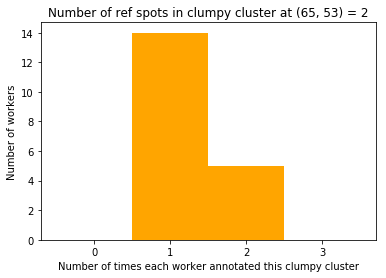

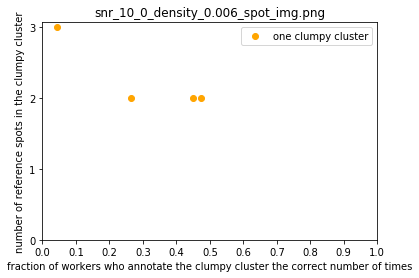

------------------- snr_10_0_density_0.008_spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  1.  3.  2.  1.  6. 27. 74.]
---
prev_count 27.0
count 6.0
threshold_drop 0.75
---
prev_count 6.0
count 1.0
threshold_drop 0.65


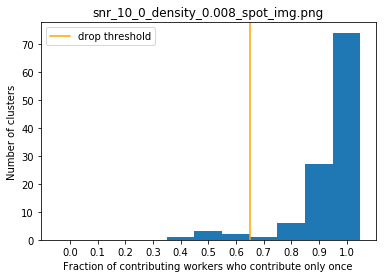

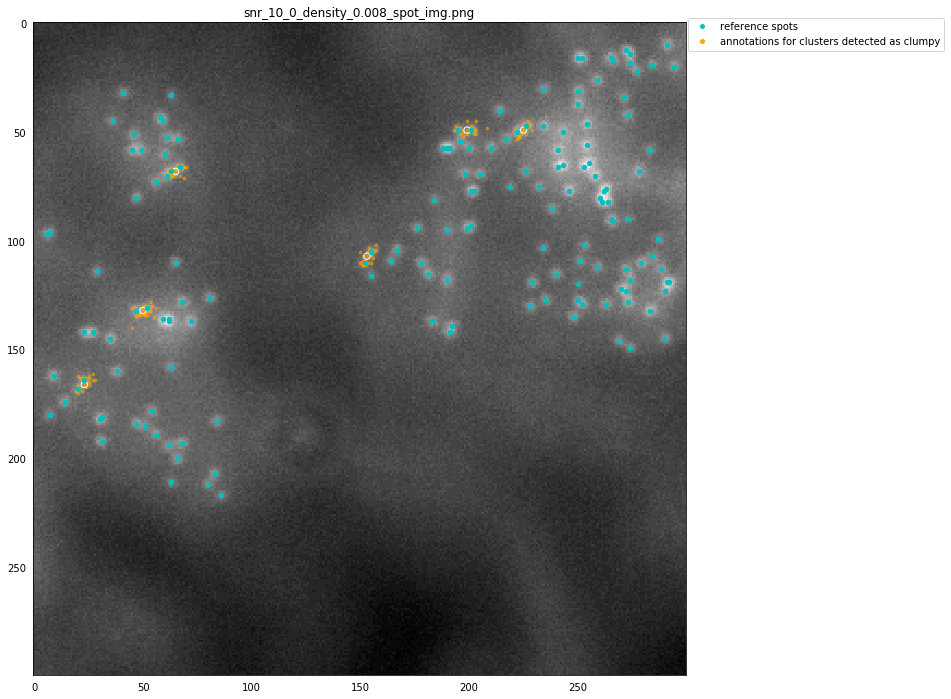

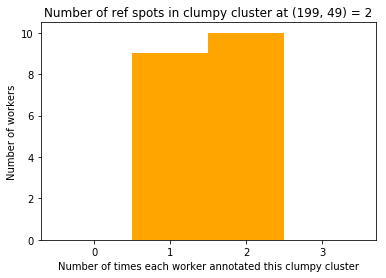

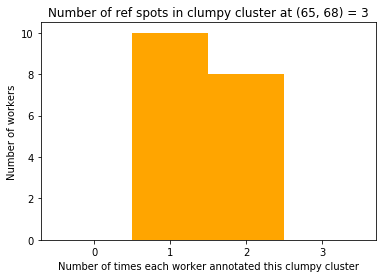

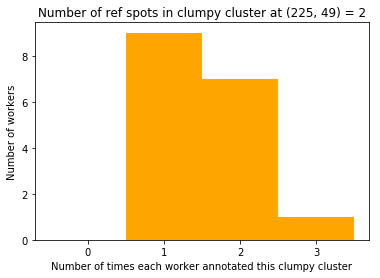

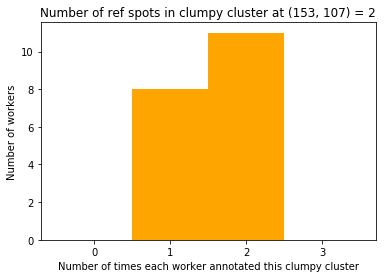

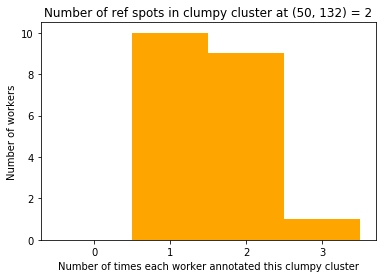

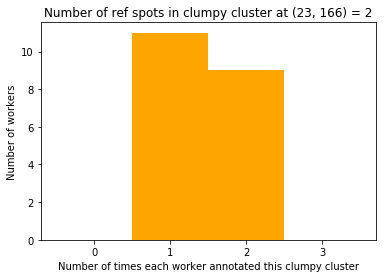

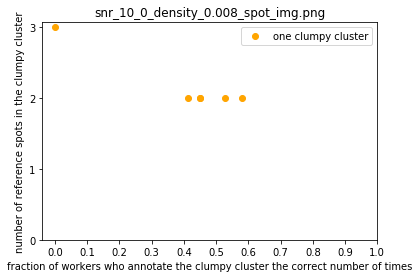

In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
# json_filename_list = ['Spot_density.json']
# density_list = [0.008]
# snr_mu_list = [10]

for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
                        
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            print('------------------- ' + img_filename + ' -------------------')
            
            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)

            # Get large clusters
            clusters = sa.get_clusters(anno_one_image, clustering_params)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)
            
            single_fraction_list = []
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])
                    
                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fraction = singles/len(unique_workers)
                single_fraction_list.append(single_fraction)
                
            # plot single fraction histogram
            fig = plt.figure()
            (n, bins, patches) = plt.hist(single_fraction_list, bins = np.arange(0,1.2,0.1)-0.05)

            # calc drop-off threshold
            total_counts = n
            print('counts:')
            print(total_counts)
            total_counts_rev = list(reversed(total_counts))
            
            threshold_drop = 0
            prev_count = 0
            for i in range(len(total_counts_rev)):
                count = total_counts_rev[i]
                if (count != 0):
                    if((count < prev_count/3) and (count != 0) and (prev_count != 0)):
                        threshold_drop = 1-i*0.1-0.05
                        print('---')
                        print('prev_count ' + str(prev_count))
                        print('count ' + str(count))
                        print('threshold_drop ' + str(round(threshold_drop,2)))
                prev_count = count
            
            plt.xlabel('Fraction of contributing workers who contribute only once')
            plt.ylabel('Number of clusters')
            plt.xticks(np.arange(0,1.1, 0.1))
            drop_line = Line2D([0],[0], color='orange', label='drop threshold')
            plt.legend(handles=[drop_line])
            plt.axvline(x=threshold_drop, color='orange')
            plt.title(img_filename)
            plt.show()
            
            # sort clusters by predicted clumpiness
            clumpy_clusters, nonclumpy_clusters = sa.sort_clusters_by_clumpiness_input_threshold(large_clusters, threshold_drop)
            
            plot_title = img_filename
            sa.plot_clusters(clumpy_clusters, img_filename, img_filepath, img_height, csv_filepath, worker_marker_size, cluster_marker_size, show_correctness, correctness_threshold, show_possible_clumps, bigger_window_size, plot_title)
            spot_count_list = []
            correct_fraction = []
            for i in range(len(clumpy_clusters.index)):
                row = clumpy_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    workers.append(member[3])
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                unique_workers = np.unique(workers)
                
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                
                # How many neighbors are in the area of this cluster?  
                centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
                dist, ind = ref_kdt.query([centroid_coord],k=3)
                spot_count = 0
                if(dist[0][0] <= 4):
                    for i in range(3):
                        index = ind[0][i]
                        spot = ref_array[index]
                        if ((spot[0] >= min(x_coords)) and (spot[0] <= max(x_coords)) and
                            (spot[1] >= min(y_coords)) and (spot[1] <= max(y_coords))):
                            spot_count += 1
                
                correct_fraction.append(num_instances_list.count(spot_count)/len(unique_workers))
                spot_count_list.append(spot_count)
                
                plt.hist(num_instances_list, bins = np.arange(0,5,1)-0.5, color='orange')
                plt.title('Number of ref spots in clumpy cluster at (' + str(centroid_coord[0]) + ', ' + str(img_height-centroid_coord[1]) + ') = ' + str(spot_count))
                plt.xticks(np.arange(0,4,1))
                plt.xlabel('Number of times each worker annotated this clumpy cluster')
                plt.ylabel('Number of workers')
                plt.show()
                
#                 run k-means with k=2		# naively assume clumpy clusters have two ref annotations associated
#                 if anyone at all annotates three times
#                     run k-means with k=3
#                     compare accuracy of clusters found with k=2 vs. k=3
            
            plt.scatter(correct_fraction, spot_count_list, c='orange')
            plt.legend(handles=[Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='orange', label='one clumpy cluster')])
            plt.xlabel('fraction of workers who annotate the clumpy cluster the correct number of times')
            plt.ylabel('number of reference spots in the clumpy cluster')
            plt.xticks(np.arange(0,1.1,0.1))
            plt.yticks(np.arange(0,4,1))
            plt.title(img_filename)
            plt.show()
                